# Food Scanner 2019

In [1]:
import warnings

import numpy as np
import pandas as pd
import pylab as plot
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import  SVR
from IPython.display import display

from module_utils.scoreRegression import scoreClassif, scoreClassifier
from module_utils.utils import head_shape, describe_plus, na_per_col, total_na_df, heatmap_isna,\
                               dist_quantitative_features, plot_mean_std, compare_plot_mean_std,\
                               plot_boxplot_outliers, violin_quantitative_features, highlight_bests_metrics,\
                               train_test_df
from module_utils.preprocess import array_to_df, msc, snv, savgol_smoothing, norml
from module_utils.model_training import train_model, compute_losses_reg, training_models

sns.set(font_scale=1.2, style="darkgrid", palette="colorblind", color_codes=True)
params = {"legend.fontsize":15,
          "legend.handlelength":2}
plot.rcParams.update(params)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../All Data (human readable column names).csv', sep = ',')

In [3]:
# drop useless columns
drop_id = ['ID', 'Surface Scan Device ID', 'Juice Scan Device ID']
df = df.drop(drop_id, axis=1)

# targets columns
target_variables = df.filter(regex="Brix|Antioxidants|Polyphenols", axis=1).columns

# Juice scans columns
juice_col = df.filter(regex="Juice", axis=1).columns
juice_target = df.filter(regex="Juice|Antioxidants|Polyphenols|Brix", axis=1).columns

# Surface scans columns
df.rename(columns={"Surface Scan 386nm":"Surface Scan 385nm"}, inplace=True)
surface_col = df.loc[:, df.columns.str.startswith("Surface")].columns
surface_target = df.filter(regex="Surface|Antioxidants|Polyphenols|Brix", axis=1).columns

# Juice and surface scans columns
surface_juice_col = surface_col.append(juice_col)
surface_juice_target = surface_juice_col.append(target_variables)

## Overview of the input variables and target variables

### 5 first lines of Surface and Juice Scans dataframe

In [4]:
head_shape(df[surface_col])
head_shape(df[juice_col].dropna())

,Surface Scan 365nm,Surface Scan 385nm,Surface Scan 450nm,Surface Scan 500nm,Surface Scan 530nm,Surface Scan 587nm,Surface Scan 632nm,Surface Scan 850nm,Surface Scan 880nm,Surface Scan 940nm
0,-59.18,-23.72,-5.215,0.49790,1.0240,6.9080,15.160,19.030,18.340,17.670
1,-191.60,-93.67,-18.970,0.02045,0.2783,7.5830,15.590,20.240,19.180,18.650
2,-125.50,-56.31,-12.560,-0.08942,1.2840,7.7250,14.050,18.110,16.580,15.560
3,-217.50,-110.30,-25.260,-2.84700,-3.2410,-2.6950,-1.539,9.315,7.702,3.101
4,-113.40,-53.12,-12.880,-1.56700,-0.9809,0.4414,2.034,12.110,12.380,11.920


(2264, 10)

,Juice Scan 365nm,Juice Scan 385nm,Juice Scan 450nm,Juice Scan 500nm,Juice Scan 530nm,Juice Scan 587nm,Juice Scan 632nm,Juice Scan 850nm,Juice Scan 880nm,Juice Scan 940nm
18,-3.52,-0.99,8.1,4.70,4.98,7.22,4.25,28.68,34.05,48.6
19,-3.46,-0.51,8.6,4.95,5.76,8.10,4.49,27.54,30.93,49.8
20,-3.53,-0.92,8.1,4.58,4.98,7.62,4.12,27.73,32.14,48.2
24,-2.10,1.70,10.9,6.51,9.02,34.78,29.49,32.20,32.68,57.0
25,-1.07,3.42,11.5,7.14,10.06,40.69,34.00,40.51,37.95,67.8


(1448, 10)

### 5 first lines of the targets dataframe

In [5]:
head_shape(df[target_variables].dropna())

,Brix,Polyphenols,Antioxidants
18,8.8,124.78,17453.50
19,5.5,132.01,18693.60
20,6.0,90.50,11900.40
24,7.5,4.33,93.73
25,7.4,3.56,107.07


(1358, 3)

## In-depth analysis
### Missing values

In [6]:
total_na_df(df)

The dataframe is made up of 68.34% missing values.


The dataframe contains a lot of NaN. We will get rid of the unnecessary columns and start to analyse the remaining columns.

In [7]:
df = df[df.columns[df.isna().sum()/df.shape[0] < 0.8]]
display(df.shape)

(2264, 56)

The dataframe went from 121 columns to 59 columns

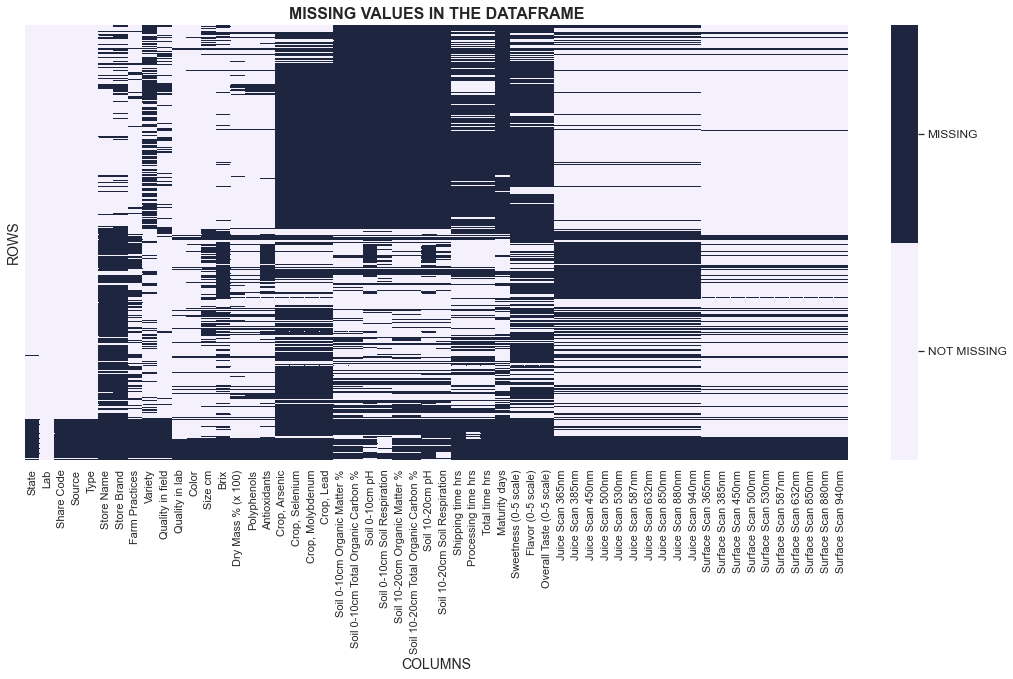

In [8]:
heatmap_isna(df)

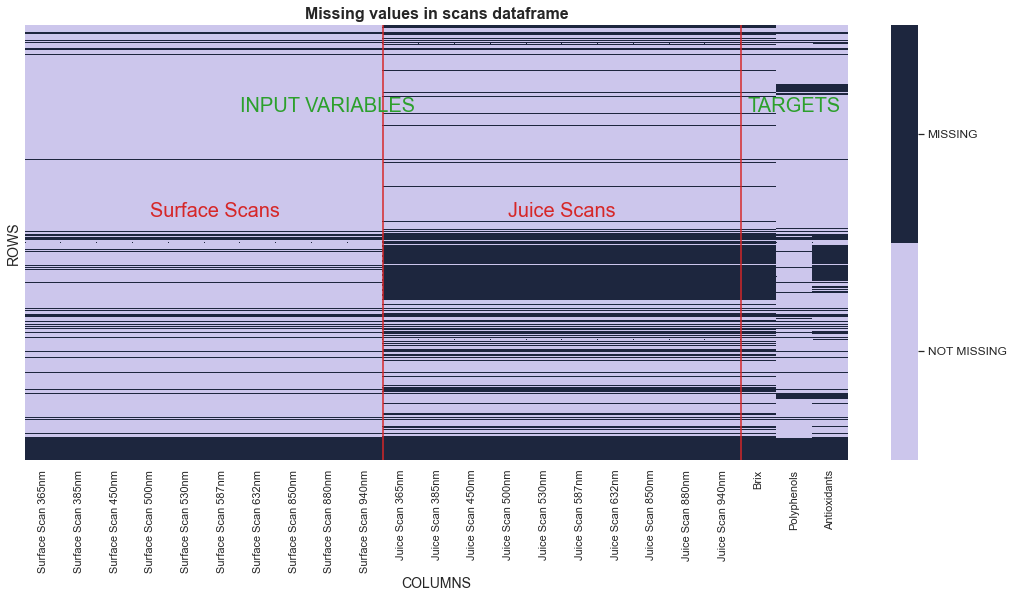

In [9]:
sns.set(font_scale=1)
cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.8, n_colors=2)
grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.1}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(16,8))

sns.heatmap(df[surface_juice_target].isna(), ax=ax, yticklabels=False, cbar_ax=cbar_ax, cmap=ListedColormap(cmap), cbar_kws={'orientation': 'vertical'})

cbar_ax.set_yticklabels(['NOT MISSING', 'MISSING'], fontsize=12)
cbar_ax.yaxis.set_ticks([ 0.25, 0.75])

# set title, x and y labels
ax.set_title('Missing values in scans dataframe', fontsize=16, fontweight="bold")
ax.set_ylabel('ROWS', fontsize=14)
ax.set_xlabel('COLUMNS', fontsize=14)

# line to separate the two columns
ax.vlines(10, *ax.get_ylim(), color="tab:red")
ax.vlines(20, *ax.get_ylim(), color="tab:red")
# categoy of the two columns
ax.text(3.5,1000, 'Surface Scans', fontsize=20, color='tab:red')
ax.text(13.5,1000, 'Juice Scans', fontsize=20, color='tab:red')
ax.text(6,450, 'INPUT VARIABLES', fontsize=20, color='tab:green')
ax.text(20.2,450, 'TARGETS', fontsize=20, color='tab:green')
_ = plt.show()

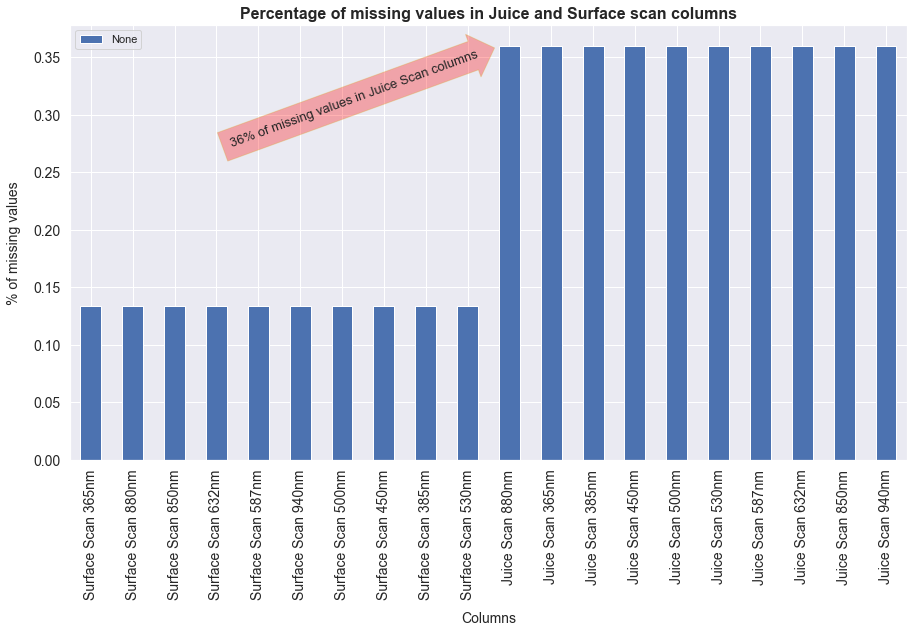

In [10]:
na_per_col(df[surface_juice_col]).plot(kind='bar',figsize=(15,8), legend=True, logy=False, fontsize=14)
plt.xlabel("Columns", fontsize=14, labelpad=12)
plt.ylabel("% of missing values", fontsize=14, labelpad=12)
plt.title("Percentage of missing values in Juice and Surface scan columns", fontsize=16, fontweight="bold")
bbox_props = dict(boxstyle="rarrow,pad=0.7", fc="RED", ec="goldenrod", lw=1, alpha=0.3)
t = plt.text(6.3, 0.314, "36% of missing values in Juice Scan columns", ha="center", va="center", rotation=20, bbox=bbox_props, fontsize=13)
bb = t.get_bbox_patch()

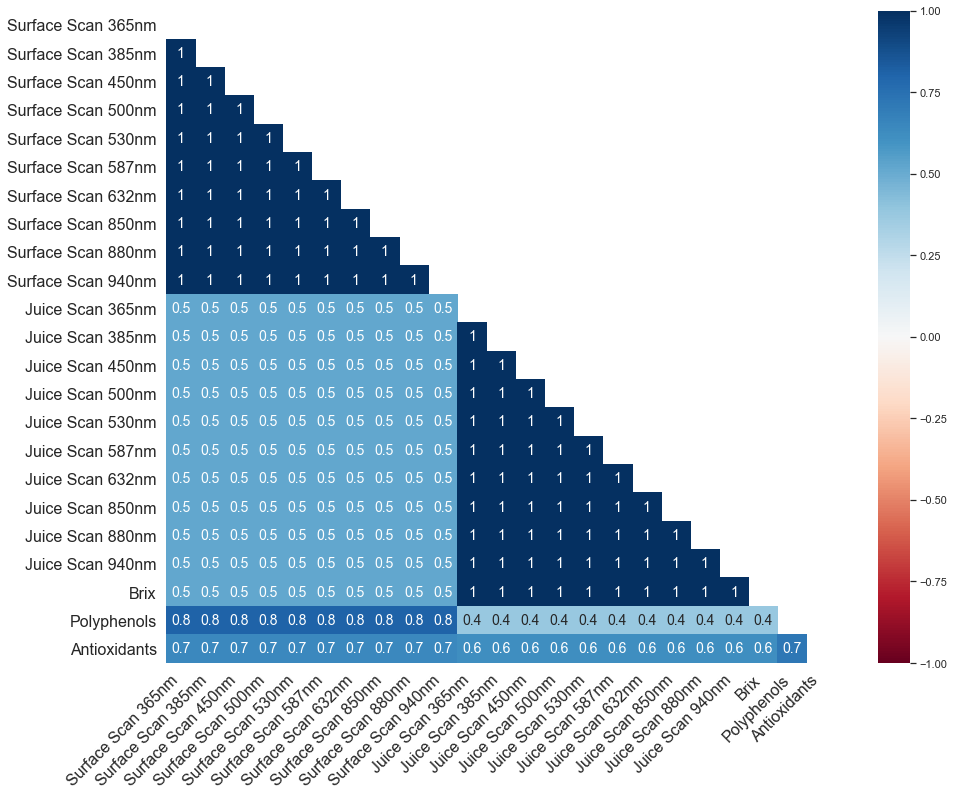

In [11]:
msno.heatmap(df[surface_juice_target], figsize=(15, 12))
_ = plt.show()

The heatmap shows the correlation between the selected columns: how strongly the presence of variable affects the presence of another. For example, Juice Scan 450 and Juice Scan 500nm are equal to 1, because this is the probability that we have the two features. We can see that the Surface Scans columns and the dependent variables (antioxidants, polyphenols) have a probability of 0.8 of complementing each other. Conversely, the probabilty to have the dependent variables (antioxidants, polyphenols) and the Juice Scan columns are 0.6 and 0.4, respectively.

## Distributions of target variables

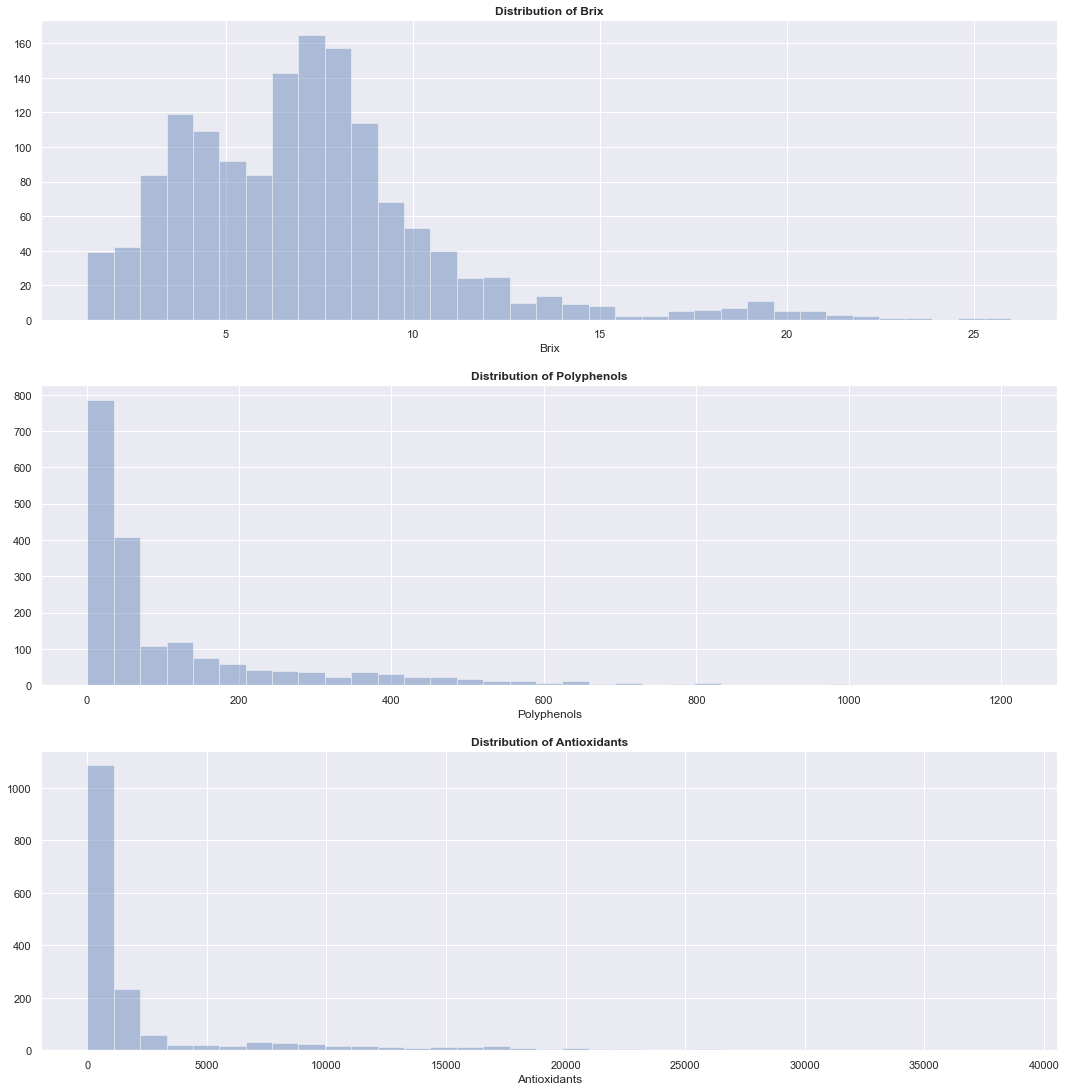

In [12]:
fig = plt.figure(figsize=(15, 15))
for i, element in enumerate(target_variables):
    fig.tight_layout(pad=1.5)
    ax = fig.add_subplot(3, 1, i+1)
    sns.distplot(df[element].dropna(), hist=True, kde=False, bins=35)
    plt.title("Distribution of {}".format(element), fontweight="bold")

### Detect outliers per type of produce

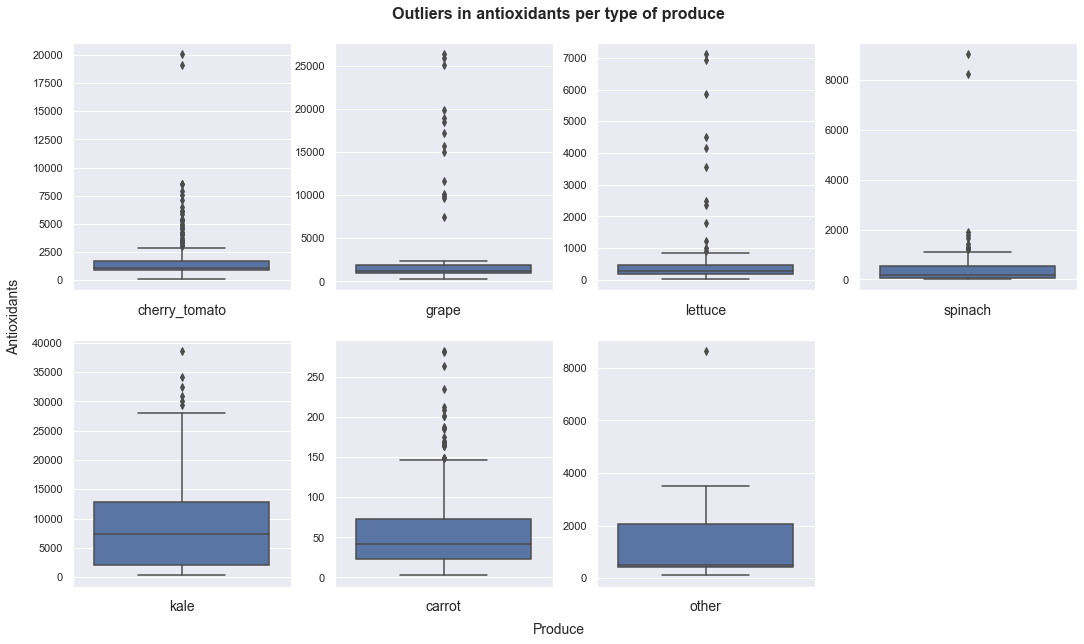

In [13]:
produce = df["Type"].unique()

plot_boxplot_outliers(dataframe=df, col="Type", cat=produce[:-1],
                      y="Antioxidants",
                      title="Outliers in antioxidants per type of produce",
                      xlabel="Produce")

## Visualization of independent variables

### Produce types

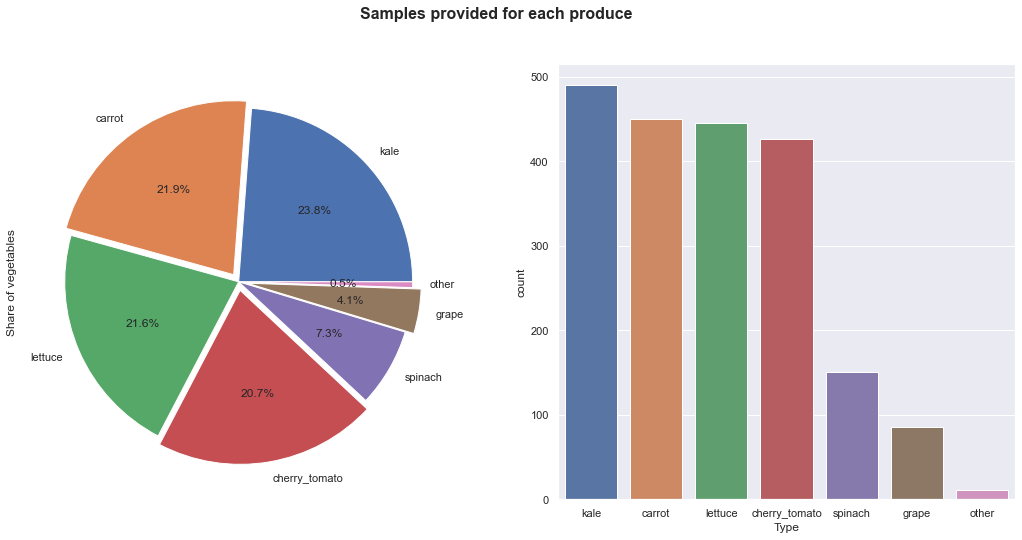

In [14]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
f.suptitle("Samples provided for each produce", fontsize=16, weight="bold")
df['Type'].value_counts().plot.pie(explode=[0,0.05,0,0.05,0,0.05,0], autopct='%1.1f%%', ax=ax[0])
ax[0].set_ylabel('Share of vegetables')
sns.countplot(x="Type", data=df, ax=ax[1], order=df['Type'].value_counts().index)
plt.show()

## Distributions of input variables

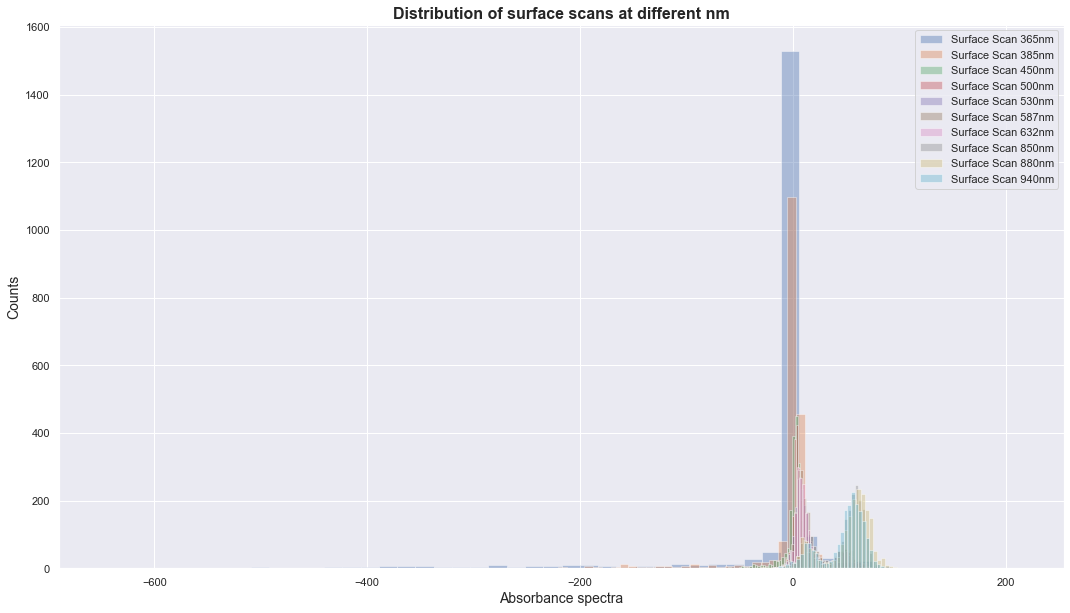

In [15]:
dist_quantitative_features(df=df, quant_feat=surface_col,
                          title="Distribution of surface scans at different nm",
                          xlabel="Absorbance spectra",
                          ylabel="Counts")

The 365 and the 385 nm surface scan values are very centered (a lot of values between -20 and 10), apart from some outliers. And the more we go up in the wavelength, the more tey are dispersed (example with 880nm and 940 nm).

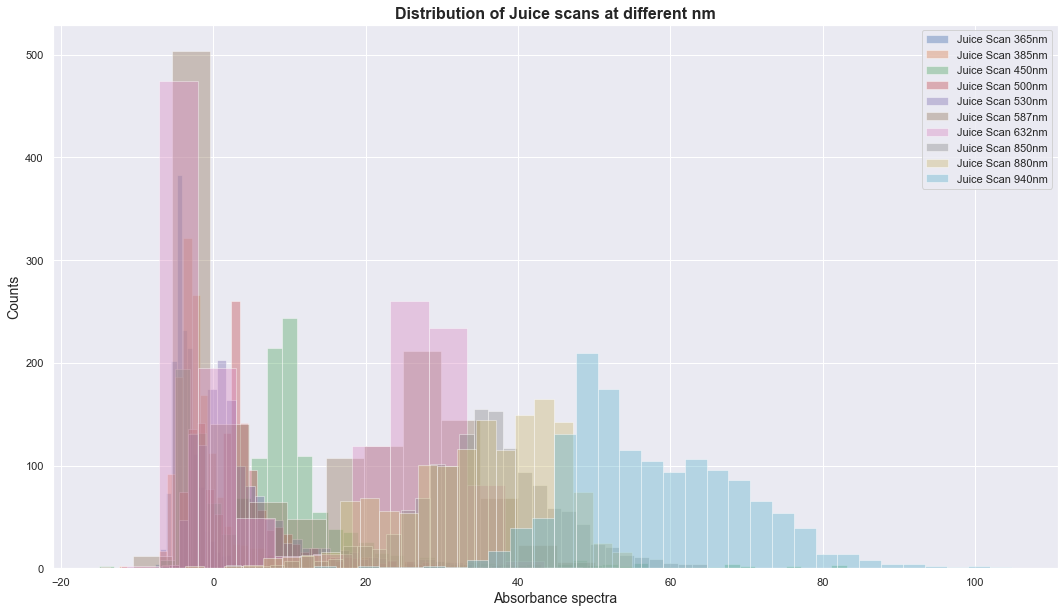

In [16]:
dist_quantitative_features(df=df, quant_feat=juice_col,
                          title="Distribution of Juice scans at different nm",
                          xlabel="Absorbance spectra",
                          ylabel="Counts")

We see roughly the same trends for Juice Scans, with a lot of centered values, then more dispersed distributions. With the difference that the juice Scan does not contain extreme outliers.

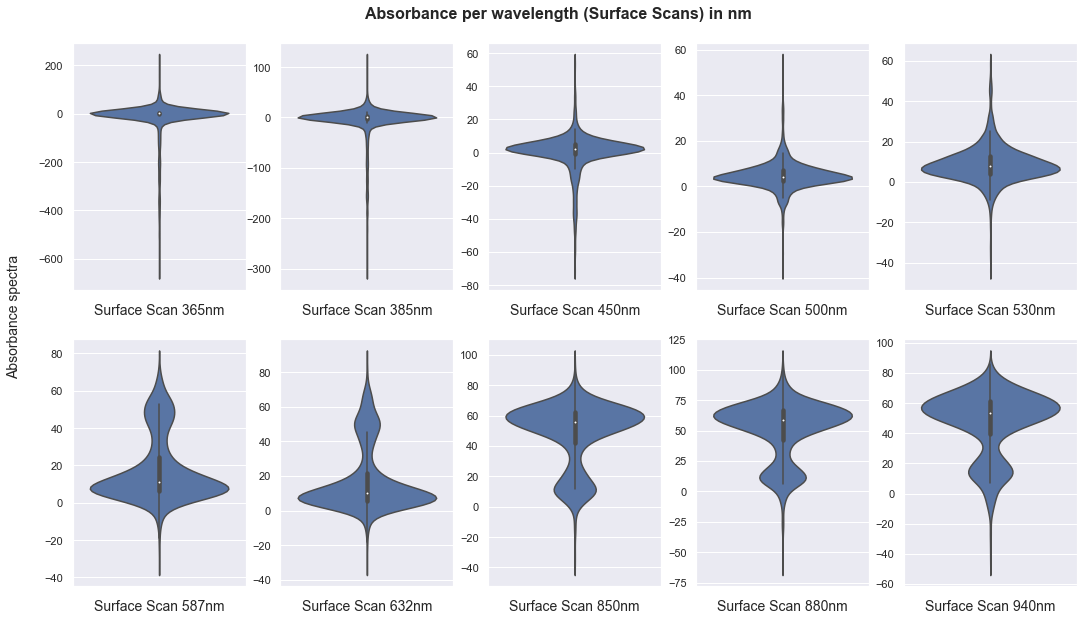

In [17]:
violin_quantitative_features(df=df, quant_feat=surface_col,
                                  title="Absorbance per wavelength (Surface Scans) in nm",
                                  ylabel="Absorbance spectra")

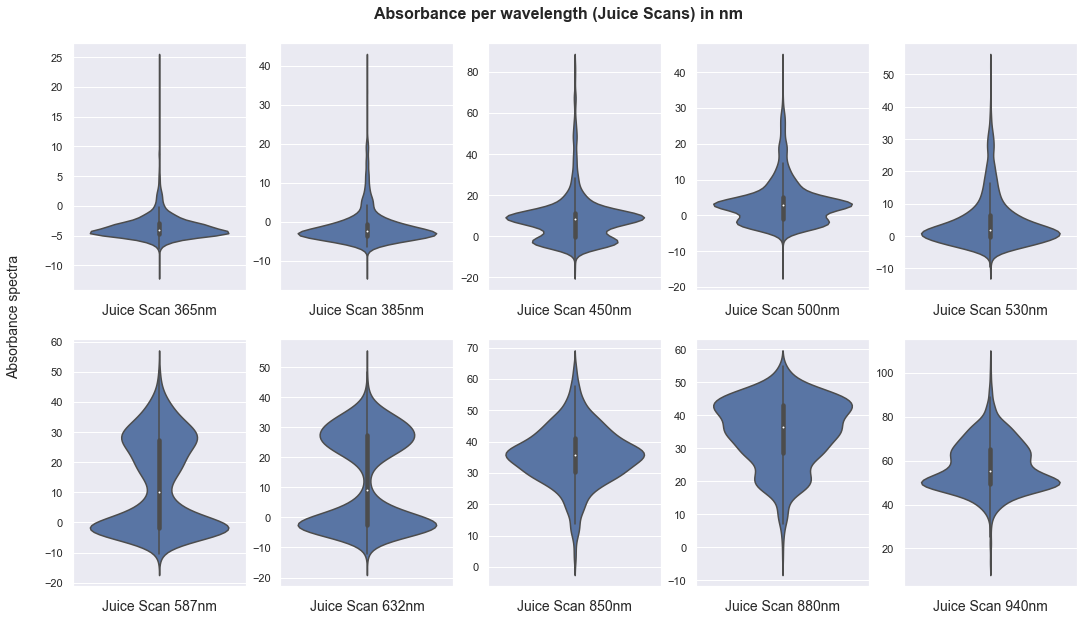

In [18]:
violin_quantitative_features(df=df, quant_feat=juice_col,
                                  title="Absorbance per wavelength (Juice Scans) in nm",
                                  ylabel="Absorbance spectra")

### Comparison mean and standard deviation of the two features scans - Surface and Juice Scans

In [19]:
df_juice = df[juice_col].rename(columns=lambda col: str(col[11:14]), inplace=False)
df_surface = df[surface_col].rename(columns=lambda col: str(col[13:16]), inplace=False)
wavelength = df_juice.columns

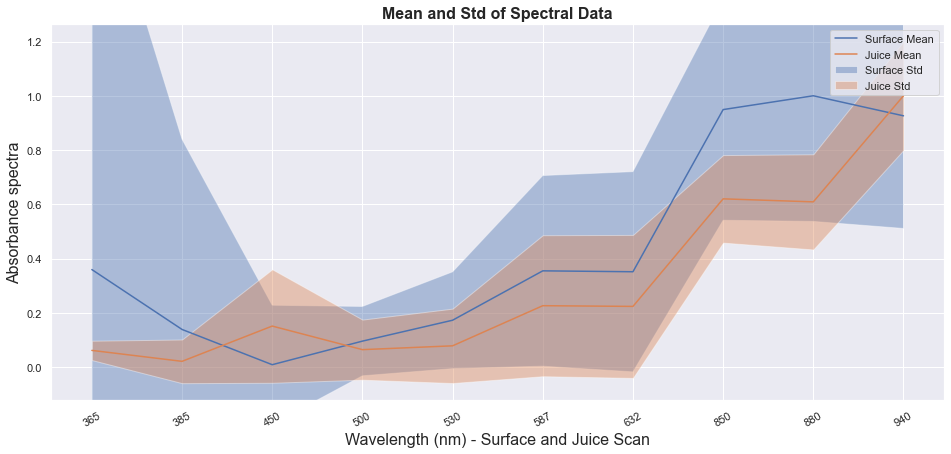

In [20]:
compare_plot_mean_std(df1 = df_surface, df2 = df_juice,
                      xlabel="Wavelength (nm) - Surface and Juice Scan", ylabel="Absorbance spectra", title="Mean and Std of Spectral Data",
                      label_mean="Surface Mean", label_std="Surface Std", label_mean2="Juice Mean", label_std2="Juice Std", figsize=(16,6))

## Baseline models for Surface scans
We are going to train several naive models without applying pre-processing methods to the input data - these anive models will serve as a basis for us to measure the impact of preprocessing methods on the input data. These methods of pre-processing aim to reduce noises and isolate important spectral characteristics.

- #### Columns: Surface Scans
- #### Type: Kale
- #### Target: Brix

In [21]:
# init model objects
lin_regression = LinearRegression()
pls = PLSRegression(n_components=5)
svr_rbf = SVR(kernel='rbf', C=10, gamma='auto', epsilon=.1, coef0=1)
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=0)
models_list = [lin_regression, pls, svr_rbf, rf_regressor]
# create list of models used for training - for columns name
models_name = ['Linear regression', 'Partial least squares', 'SVR RBF', 'RF regressor']

In [22]:
x = df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Polyphenols', 'Antioxidants'], axis=1).values
y = df[df["Type"]=="kale"][surface_target].dropna().iloc[:,0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [23]:
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.812678,1.805047,0.097877,0.740777
MSE,5.219343,5.235962,0.009720,0.844027
R2,0.149150,0.146440,0.998415,0.862408
RMSE,2.284588,2.288222,0.098589,0.918709
Score Classifier,0.617647,0.611765,0.988235,0.923529


In [24]:
train_test_df(df_1=train_df, df_2=test_df, column='SVR RBF')

,Train,Test
SVR RBF,,
MAE,0.097877,0.098284
MSE,0.009720,0.009779
R2,0.998415,0.998124
RMSE,0.098589,0.098887
Score Classifier,0.988235,0.972603


## Preprocessing and trainings
The goal of data preprocessing is to eliminate or minimize wavelength variability.
http://www.models.life.ku.dk/sites/default/files/preproNIR.pdf

### Multiplicative Scatter Correction
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

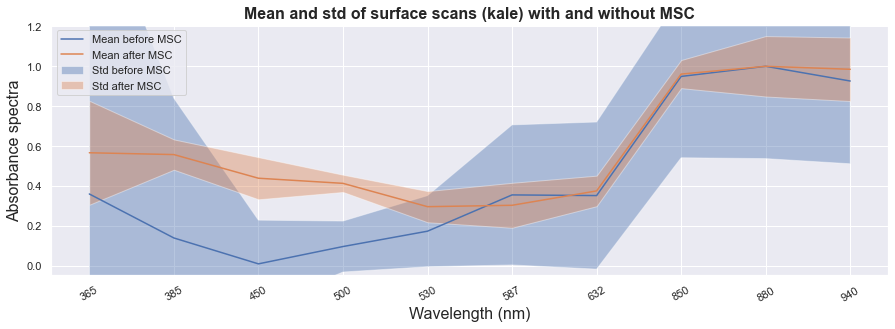

In [25]:
# Apply MSC method on our input variables
x_msc, msc_df = array_to_df(x, msc,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=msc_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without MSC",
                     label_mean="Mean before MSC", label_std="Std before MSC", label_mean2="Mean after MSC", label_std2="Std after MSC")

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_msc, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.823824,1.847906,0.165818,0.706547
MSE,5.249338,5.311783,0.156616,0.831193
R2,0.144260,0.134080,0.974469,0.864500
RMSE,2.291143,2.304731,0.395747,0.911698
Score Classifier,0.617647,0.600000,0.976471,0.935294


In [27]:
train_test_df(df_1=train_df, df_2=test_df, column='SVR RBF')

,Train,Test
SVR RBF,,
MAE,0.165818,0.117631
MSE,0.156616,0.036726
R2,0.974469,0.992953
RMSE,0.395747,0.191640
Score Classifier,0.976471,0.958904


### Standard Normal Variate
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

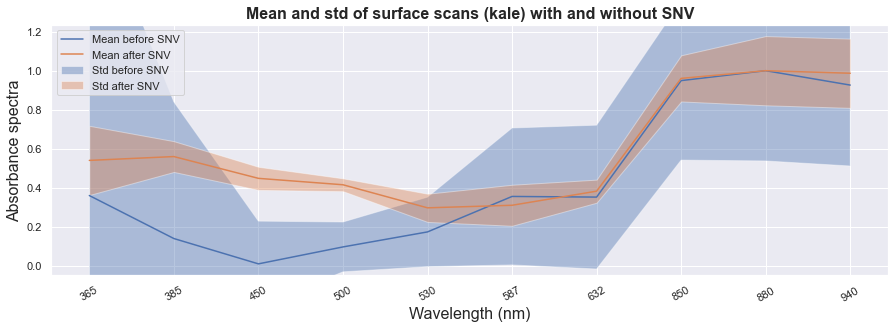

In [28]:
# Apply SNV method on our input variables
x_snv, snv_df = array_to_df(x, snv,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=snv_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without SNV",
                     label_mean="Mean before SNV", label_std="Std before SNV", label_mean2="Mean after SNV", label_std2="Std after SNV")

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_snv, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.830165,1.847155,1.850371,0.708702
MSE,5.268467,5.322486,5.473067,0.826264
R2,0.141141,0.132335,0.107788,0.865303
RMSE,2.295314,2.307051,2.339459,0.908991
Score Classifier,0.611765,0.623529,0.576471,0.935294


In [30]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,0.708702,0.707948
MSE,0.826264,0.784915
R2,0.865303,0.849381
RMSE,0.908991,0.885954
Score Classifier,0.935294,0.863014


### Savitsky-Golay
https://nirpyresearch.com/savitzky-golay-smoothing-method/

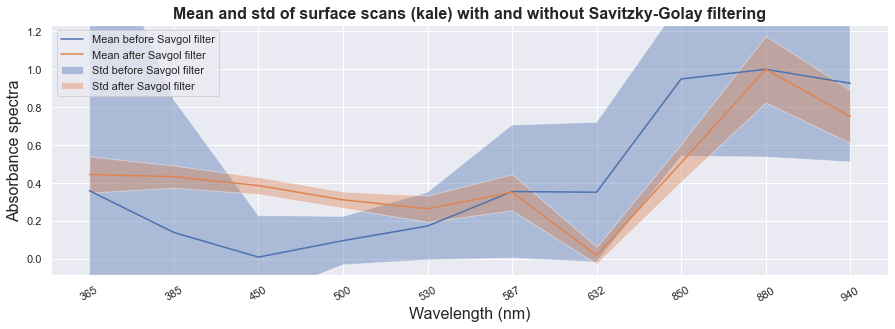

In [31]:
# Apply svagol_filter method on our input variables
x_savgol, savgol_df = array_to_df(x, savgol_smoothing,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=savgol_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Savitzky-Golay filtering",
                     label_mean="Mean before Savgol filter", label_std="Std before Savgol filter", label_mean2="Mean after Savgol filter", label_std2="Std after Savgol filter")

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_savgol, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.822813,1.850505,0.129450,0.737754
MSE,5.222616,5.361806,0.103191,0.864798
R2,0.148616,0.125926,0.983178,0.859022
RMSE,2.285304,2.315557,0.321234,0.929945
Score Classifier,0.623529,0.605882,0.982353,0.935294


In [33]:
train_test_df(df_1=train_df, df_2=test_df, column='SVR RBF')

,Train,Test
SVR RBF,,
MAE,0.129450,0.099793
MSE,0.103191,0.009962
R2,0.983178,0.998088
RMSE,0.321234,0.099811
Score Classifier,0.982353,0.972603


### Spectral normalisation

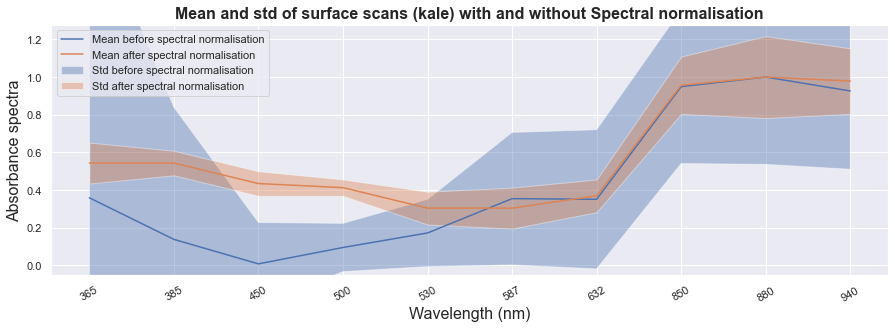

In [34]:
# Apply Spectral normalisation method on our input variables
x_norml, norml_df = array_to_df(x, norml,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=norml_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Spectral normalisation",
                     label_mean="Mean before spectral normalisation", label_std="Std before spectral normalisation", label_mean2="Mean after spectral normalisation", label_std2="Std after spectral normalisation")

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_norml, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.817498,1.838536,1.900013,0.737447
MSE,5.227426,5.270870,5.776988,0.863298
R2,0.147832,0.140750,0.058243,0.859266
RMSE,2.286356,2.295838,2.403537,0.929138
Score Classifier,0.611765,0.617647,0.582353,0.900000


In [36]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,0.737447,0.701122
MSE,0.863298,0.821470
R2,0.859266,0.842366
RMSE,0.929138,0.906350
Score Classifier,0.900000,0.835616


- #### Columns: Surface Scans
- #### Type: Kale
- #### Target: Polyphenols

In [37]:
x = df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Polyphenols', 'Antioxidants'], axis=1).values
y = df[df["Type"]=="kale"][surface_target].dropna().iloc[:,1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [38]:
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,142.315075,147.581199,154.846560,57.735225
MSE,34537.314699,35974.395988,46006.405934,5588.398627
R2,0.244515,0.213080,-0.006365,0.877757
RMSE,185.842177,189.669175,214.491039,74.755593
Score Classifier,0.647059,0.641176,1.000000,0.911765


In [39]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,57.735225,52.601480
MSE,5588.398627,3772.569982
R2,0.877757,0.872253
RMSE,74.755593,61.421250
Score Classifier,0.911765,0.904110


## Preprocessing and trainings
The goal of data preprocessing is to eliminate or minimize wavelength variability.
http://www.models.life.ku.dk/sites/default/files/preproNIR.pdf

### Multiplicative Scatter Correction
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

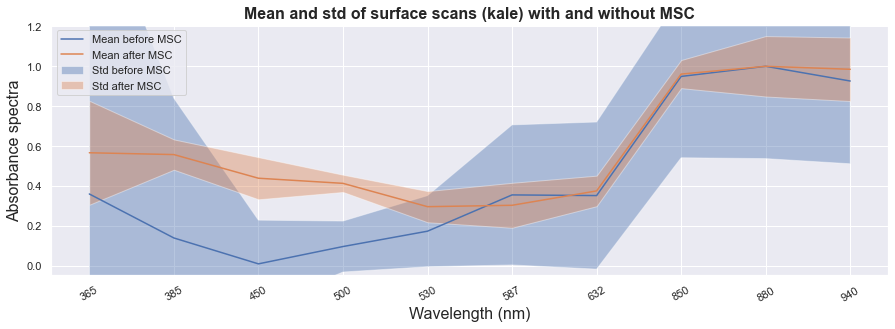

In [40]:
# Apply MSC method on our input variables
x_msc, msc_df = array_to_df(x, msc,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=msc_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without MSC",
                     label_mean="Mean before MSC", label_std="Std before MSC", label_mean2="Mean after MSC", label_std2="Std after MSC")

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x_msc, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,147.029412,147.492339,154.765507,56.867268
MSE,37244.195114,37783.550765,45771.829091,5426.771598
R2,0.185303,0.173505,-0.001234,0.881292
RMSE,192.987552,194.379913,213.943518,73.666625
Score Classifier,0.611765,0.617647,0.917647,0.911765


In [42]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,56.867268,59.579235
MSE,5426.771598,4970.784386
R2,0.881292,0.831679
RMSE,73.666625,70.503790
Score Classifier,0.911765,0.890411


### Standard Normal Variate
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

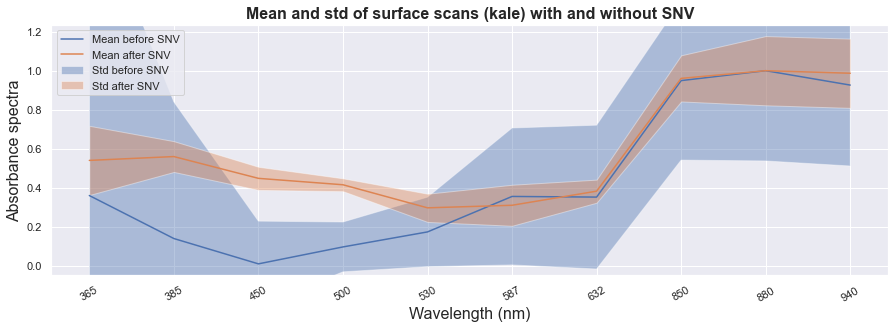

In [43]:
# Apply SNV method on our input variables
x_snv, snv_df = array_to_df(x, snv,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=snv_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without SNV",
                     label_mean="Mean before SNV", label_std="Std before SNV", label_mean2="Mean after SNV", label_std2="Std after SNV")

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x_snv, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,143.009304,144.892787,161.175672,57.096088
MSE,35019.316472,36721.790776,48202.919254,5373.263356
R2,0.233971,0.196731,-0.054413,0.882463
RMSE,187.134488,191.629306,219.551632,73.302547
Score Classifier,0.647059,0.647059,0.641176,0.941176


In [45]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,57.096088,60.058827
MSE,5373.263356,5047.651054
R2,0.882463,0.829077
RMSE,73.302547,71.046823
Score Classifier,0.941176,0.863014


### Savitsky-Golay
https://nirpyresearch.com/savitzky-golay-smoothing-method/

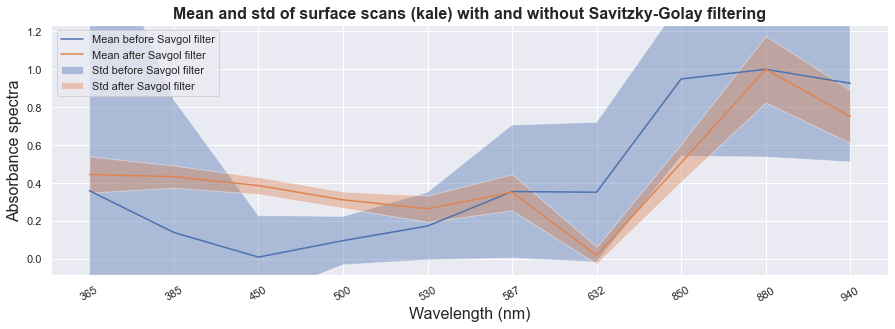

In [46]:
# Apply svagol_filter method on our input variables
x_savgol, savgol_df = array_to_df(x, savgol_smoothing,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=savgol_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Savitzky-Golay filtering",
                     label_mean="Mean before Savgol filter", label_std="Std before Savgol filter", label_mean2="Mean after Savgol filter", label_std2="Std after Savgol filter")

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_savgol, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,145.649168,149.629619,154.065097,61.342101
MSE,36911.625518,39333.526246,46040.053256,6215.316198
R2,0.192578,0.139600,-0.007101,0.864043
RMSE,192.123985,198.326817,214.569460,78.837277
Score Classifier,0.623529,0.623529,0.917647,0.905882


In [48]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,61.342101,53.137071
MSE,6215.316198,4163.464394
R2,0.864043,0.859017
RMSE,78.837277,64.524913
Score Classifier,0.905882,0.890411


### Spectral normalisation

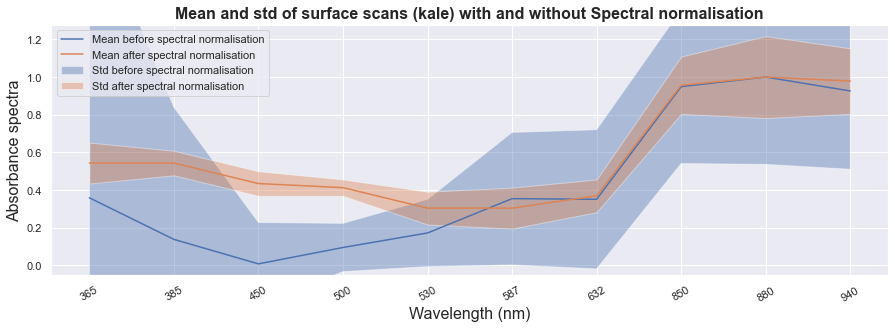

In [49]:
# Apply Spectral normalisation method on our input variables
x_norml, norml_df = array_to_df(x, norml,
           index=df[df["Type"]=="kale"][surface_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=norml_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of surface scans (kale) with and without Spectral normalisation",
                     label_mean="Mean before spectral normalisation", label_std="Std before spectral normalisation", label_mean2="Mean after spectral normalisation", label_std2="Std after spectral normalisation")

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_norml, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,146.180518,146.492703,164.410395,59.404266
MSE,36995.281100,37170.258558,49020.304147,5813.699717
R2,0.190748,0.186921,-0.072293,0.872828
RMSE,192.341574,192.795899,221.405294,76.247621
Score Classifier,0.611765,0.629412,0.617647,0.888235


In [51]:
train_test_df(df_1=train_df, df_2=test_df, column='RF regressor')

,Train,Test
RF regressor,,
MAE,59.404266,52.730889
MSE,5813.699717,4185.819185
R2,0.872828,0.858260
RMSE,76.247621,64.697907
Score Classifier,0.888235,0.931507


## Baseline models for Juice scans
We are going to train several naive models without applying pre-processing methods to the input data - these anive models will serve as a basis for us to measure the impact of preprocessing methods on the input data. These methods of pre-processing aim to reduce noises and isolate important spectral characteristics.

- #### Columns: Juice Scans
- #### Type: Kale
- #### Target: Brix

In [52]:
x = df[df["Type"]=="kale"][juice_target].dropna().drop(['Brix', 'Polyphenols', 'Antioxidants'], axis=1).values
y = df[df["Type"]=="kale"][juice_target].dropna().iloc[:,0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [53]:
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.463719,1.504797,0.212425,0.585295
MSE,3.675778,3.801682,0.349865,0.606474
R2,0.394946,0.374221,0.942410,0.900171
RMSE,1.917232,1.949790,0.591494,0.778765
Score Classifier,0.710059,0.704142,0.970414,0.905325


In [54]:
train_test_df = pd.concat([train_df[['SVR RBF']], test_df[['SVR RBF']]], axis=1)
train_test_df.index.name = "SVR RBF"
train_test_df.columns = ['Train', 'Test']
highlight_bests_metrics(train_test_df)

,Train,Test
SVR RBF,,
MAE,0.212425,0.177243
MSE,0.349865,0.252228
R2,0.942410,0.949590
RMSE,0.591494,0.502223
Score Classifier,0.970414,0.958904


## Preprocessing and trainings
The goal of data preprocessing is to eliminate or minimize wavelength variability.
http://www.models.life.ku.dk/sites/default/files/preproNIR.pdf

### Multiplicative Scatter Correction
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

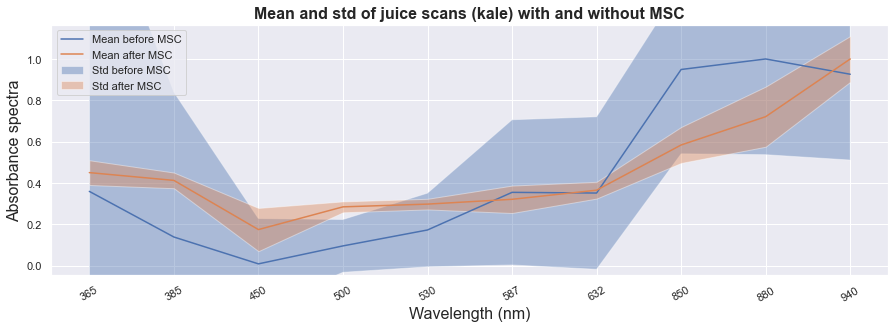

In [55]:
# Apply MSC method on our input variables
x_msc, msc_df = array_to_df(x, msc,
           index=df[df["Type"]=="kale"][juice_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=msc_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without MSC",
                     label_mean="Mean before MSC", label_std="Std before MSC", label_mean2="Mean after MSC", label_std2="Std after MSC")

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x_msc, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.551775,1.537428,0.470711,0.543098
MSE,3.874157,3.959721,0.829589,0.546186
R2,0.362292,0.348207,0.863445,0.910095
RMSE,1.968288,1.989905,0.910818,0.739044
Score Classifier,0.704142,0.692308,0.911243,0.928994


In [57]:
train_test_df = pd.concat([train_df[['RF regressor']], test_df[['RF regressor']]], axis=1)
train_test_df.index.name = "RF regressor"
train_test_df.columns = ['Train', 'Test']
highlight_bests_metrics(train_test_df)

,Train,Test
RF regressor,,
MAE,0.543098,0.610715
MSE,0.546186,0.644346
R2,0.910095,0.871221
RMSE,0.739044,0.802711
Score Classifier,0.928994,0.945205


### Standard Normal Variate
https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

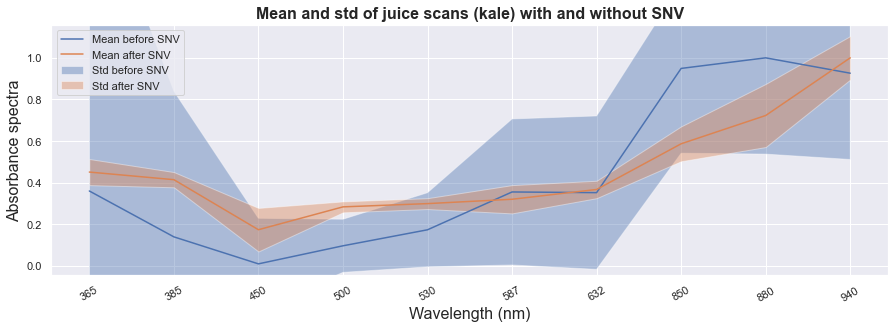

In [58]:
# Apply SNV method on our input variables
x_snv, snv_df = array_to_df(x, snv,
           index=df[df["Type"]=="kale"][juice_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=snv_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without SNV",
                     label_mean="Mean before SNV", label_std="Std before SNV", label_mean2="Mean after SNV", label_std2="Std after SNV")

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x_snv, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.520305,1.540436,1.661430,0.548561
MSE,3.887463,3.957273,4.593551,0.550003
R2,0.360102,0.348610,0.243875,0.909466
RMSE,1.971665,1.989290,2.143257,0.741622
Score Classifier,0.680473,0.692308,0.656805,0.911243


In [60]:
train_test_df = pd.concat([train_df[['RF regressor']], test_df[['RF regressor']]], axis=1)
train_test_df.index.name = "RF regressor"
train_test_df.columns = ['Train', 'Test']
highlight_bests_metrics(train_test_df)

,Train,Test
RF regressor,,
MAE,0.548561,0.605110
MSE,0.550003,0.628922
R2,0.909466,0.874303
RMSE,0.741622,0.793046
Score Classifier,0.911243,0.958904


### Savitsky-Golay
https://nirpyresearch.com/savitzky-golay-smoothing-method/

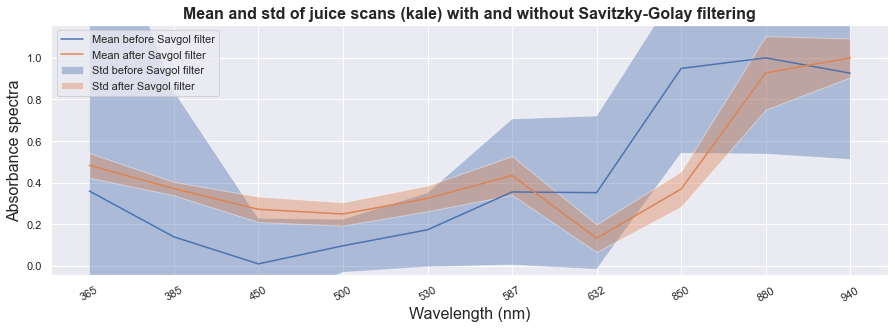

In [61]:
# Apply svagol_filter method on our input variables
x_savgol, savgol_df = array_to_df(x, savgol_smoothing,
           index=df[df["Type"]=="kale"][juice_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=savgol_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without Savitzky-Golay filtering",
                     label_mean="Mean before Savgol filter", label_std="Std before Savgol filter", label_mean2="Mean after Savgol filter", label_std2="Std after Savgol filter")

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x_savgol, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.495943,1.528295,0.490180,0.600476
MSE,3.745720,3.893209,0.926831,0.616369
R2,0.383433,0.359156,0.847438,0.898542
RMSE,1.935386,1.973122,0.962720,0.785092
Score Classifier,0.698225,0.733728,0.923077,0.893491


In [63]:
train_test_df = pd.concat([train_df[['RF regressor']], test_df[['RF regressor']]], axis=1)
train_test_df.index.name = "RF regressor"
train_test_df.columns = ['Train', 'Test']
highlight_bests_metrics(train_test_df)

,Train,Test
RF regressor,,
MAE,0.600476,0.678936
MSE,0.616369,0.823110
R2,0.898542,0.835493
RMSE,0.785092,0.907254
Score Classifier,0.893491,0.958904


### Spectral normalisation

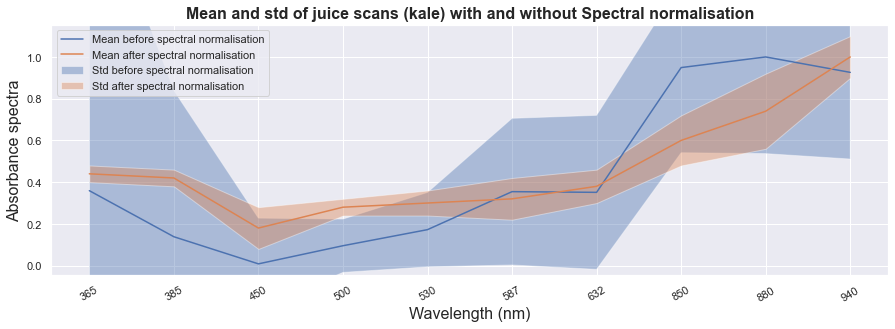

In [64]:
# Apply Spectral normalisation method on our input variables
x_norml, norml_df = array_to_df(x, norml,
           index=df[df["Type"]=="kale"][juice_target].dropna().drop(['Brix', 'Antioxidants'], axis=1).index,
           columns=df_surface.columns)
compare_plot_mean_std(df1=df_surface, df2=norml_df, xlabel="Wavelength (nm)", ylabel="Absorbance spectra",
                     title="Mean and std of juice scans (kale) with and without Spectral normalisation",
                     label_mean="Mean before spectral normalisation", label_std="Std before spectral normalisation", label_mean2="Mean after spectral normalisation", label_std2="Std after spectral normalisation")

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x_norml, y, test_size=0.30, random_state=42)
train_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_train, y=y_train, col_name=models_name)
test_df = training_models(models=[lin_regression, pls, svr_rbf, rf_regressor], x=x_test, y=y_test, col_name=models_name)
highlight_bests_metrics(train_df)

,Linear regression,Partial least squares,SVR RBF,RF regressor
MAE,1.490889,1.527004,1.864451,0.584259
MSE,3.747559,3.844344,5.549634,0.611157
R2,0.383130,0.367199,0.086499,0.899400
RMSE,1.935861,1.960700,2.355766,0.781765
Score Classifier,0.710059,0.710059,0.591716,0.893491


In [66]:
train_test_df = pd.concat([train_df[['RF regressor']], test_df[['RF regressor']]], axis=1)
train_test_df.index.name = "RF regressor"
train_test_df.columns = ['Train', 'Test']
highlight_bests_metrics(train_test_df)

,Train,Test
RF regressor,,
MAE,0.584259,0.563201
MSE,0.611157,0.585724
R2,0.899400,0.882937
RMSE,0.781765,0.765326
Score Classifier,0.893491,0.958904
